<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC 
## Comparing timeseries between sites and between years (climatology)

Example script to plot the monthly mean NO2 mass concentration data for 2022 from all ACTRIS stations. Data are plotted as timeseries as well as on a map. Further, the script includes an example of 15 years of data from one site comparing the monthly concentration in 20222 with earlier years


### Import libraries

In [1]:

import xarray as xr
import threddsclient
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap

ModuleNotFoundError: No module named 'cartopy'

### Load data
The data we want to look at are selected from the ACTRIS web portal and a json file with the URLs to their netCDF files are dowloades

In [2]:
# load the basket.json file downloaded from the ACTRIS Data portal
with open('basket.json') as f:
  basket = json.load(f)

# get the list of the urls in the NO2 files in netCDF format
df = pd.DataFrame(basket).T
file_urls = df['opendapUrl'].tolist()
print(file_urls)

['https://thredds.nilu.no/thredds/dodsC/ebas_doi/JE/CK/XJ/JECK-XJ9C.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/XC/VP/A5/XCVP-A5BH.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/3M/9Z/64/3M9Z-648F.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/9K/6S/D6/9K6S-D6A9.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/DQ/83/EQ/DQ83-EQBE.nc']


In [4]:
# define the variable of interest and the year of interest
variable_interested_standard_name = 'mass_concentration_of_nitrogen_dioxide_expressed_as_nitrogen_in_air'
year_interested = 2022

### Calculate monthly mean concentrations

In [7]:
daily_means_all_sites = []
monthly_means_all_sites = []
site_name_list = []

for i in range(len(file_urls)):
    # Open the netCDF file
    data = xr.open_dataset(file_urls[i])
    print(i)

    # Check if the dataset's time range overlaps with the wanted period
    dataset_start_time = data.time.min().values
    dataset_end_time = data.time.max().values


    # check time period of the data
    if (data.time.dt.year == year_interested).any():

        # check if the dataset contains the variable of interest
        for var in data.data_vars:
            if 'standard_name' in data[var].attrs and data[var].attrs['standard_name'] == variable_interested_standard_name:
                print(' File %d, %s, variable: %s %s Period: %s - %s' % (i, data.attrs['ebas_station_code'], "{:<35s}".format(var), "{:<40s}".format('('+data.attrs['ebas_station_name']+')'), data.time.min().values, data.time.max().values))

                # get the variable values for the year of interest
                variable_values = data[var].sel(time = data.time.dt.year == year_interested)

                # Calculate daily and monthly means
                daily_means = variable_values.resample(time='1D').mean('time')
                print('      ..has data for '+str(len(daily_means))+' days..')
                monthly_means = variable_values.resample(time='1M').mean('time')
                daily_means_all_sites.append(daily_means)
                monthly_means_all_sites.append(monthly_means)
                site_name_list.append(data.attrs['ebas_station_name'])
                break              

    else:
        print(f"File {i} does not contain data in the desired time range.")
    data.close() 

0
 File 0, FI0050R, variable: nitrogen_dioxide_ug_N_per_m3_amean  (Hyytiälä)                               Period: 2018-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..there is data for 365 days..


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


     ..done calculating daily/monthly means and such..
1
 File 1, IT0009R, variable: nitrogen_dioxide_ug_N_per_m3_amean  (Monte Cimone)                           Period: 2021-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..there is data for 365 days..
     ..done calculating daily/monthly means and such..


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


2
 File 2, CZ0003R, variable: nitrogen_dioxide_ug_N_per_m3        (Kosetice (NAOK))                        Period: 2022-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..there is data for 365 days..
     ..done calculating daily/monthly means and such..
3
 File 3, FR0020R, variable: nitrogen_dioxide_ug_N_per_m3        (SIRTA Atmospheric Research Observatory) Period: 2022-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


      ..there is data for 365 days..
     ..done calculating daily/monthly means and such..
4
 File 4, CH0001G, variable: nitrogen_dioxide_ug_N_per_m3        (Jungfraujoch)                           Period: 2021-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


      ..there is data for 365 days..
     ..done calculating daily/monthly means and such..


<string>:6: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.


Make a plot with several panels - one for each station - showing daily mean and monthly mean values for the chosen year

['Hyytiälä', 'Monte Cimone', 'Kosetice (NAOK)', 'SIRTA Atmospheric Research Observatory', 'Jungfraujoch']


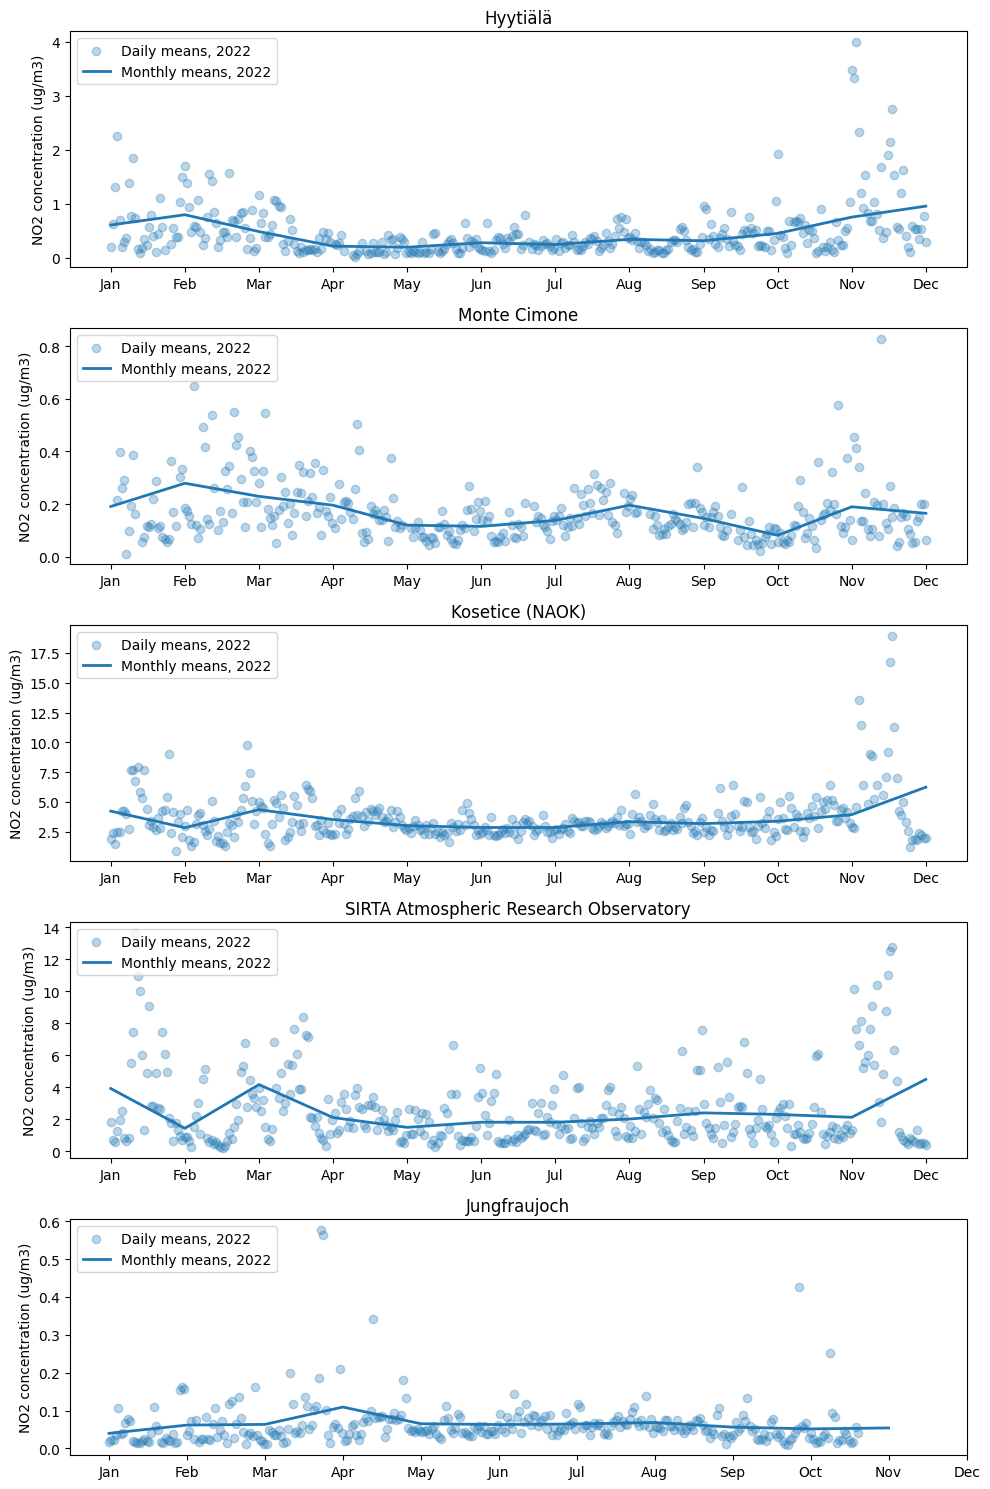

In [14]:


#First, prepare some variables to use as x values in the plotting
ndays=len(daily_means.time)
nmonths=len(monthly_means.time)
days=np.linspace(1,ndays,ndays)
monthsdaily=np.linspace(1,nmonths,ndays)    #x values for the daily mean dots in the plot
months=np.linspace(1,nmonths,nmonths)       #x values for the monthly mean lines in the plot

nstations=len(site_name_list)
print(site_name_list)

# Prepare the figure. panelheight can be varied.
panelheight=3
fig, axes = plt.subplots(nrows=nstations,ncols=1, figsize=(10,int(panelheight*len(site_name_list))))

for col in range(0,nstations):
    ax=axes[col]
    ax.scatter(monthsdaily,daily_means_all_sites[col],label='Daily means, '+str(year_interested),alpha=0.3) #scatterplot of daily mean values
    ax.plot(months,monthly_means_all_sites[col],label='Monthly means, '+str(year_interested),linewidth=2) #line plot of monthly mean values
    ax.set_ylabel('NO2 concentration (ug/m3)')
    ax.set_title(site_name_list[col])
    ax.legend(loc='upper left')
    ax.set_xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


plt.tight_layout()
plt.show()
plt.close()

### Make a plot where the monthly mean data is plotted in the same panel

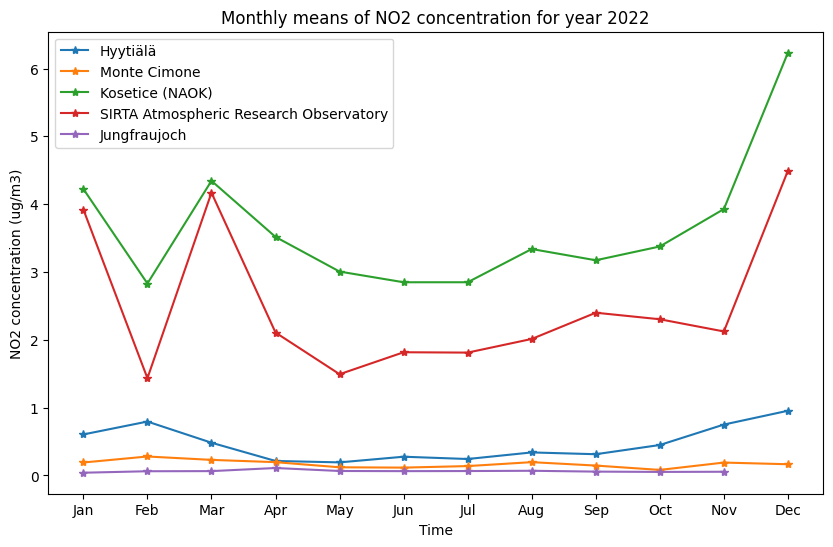

In [11]:
plt.figure(figsize=(10, 6))
for i in range(len(monthly_means_all_sites)):
    plt.plot(monthly_means_all_sites[i], label=site_name_list[i], marker='*')

plt.legend()
plt.xlabel('Time')
plt.ylabel('NO2 concentration (ug/m3)')
plt.title('Monthly means of NO2 concentration for year %d' % year_interested)
plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig('NO2_monthly_means_multi_sites.png')
plt.show()
plt.close()

### Make a map plot, marking each station as a circle colored by its average value of NO2

/tmp/ipykernel_910/2179420240.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('afmhot').reversed()  # Choose your colormap, e.g., 'viridis', 'plasma', etc.


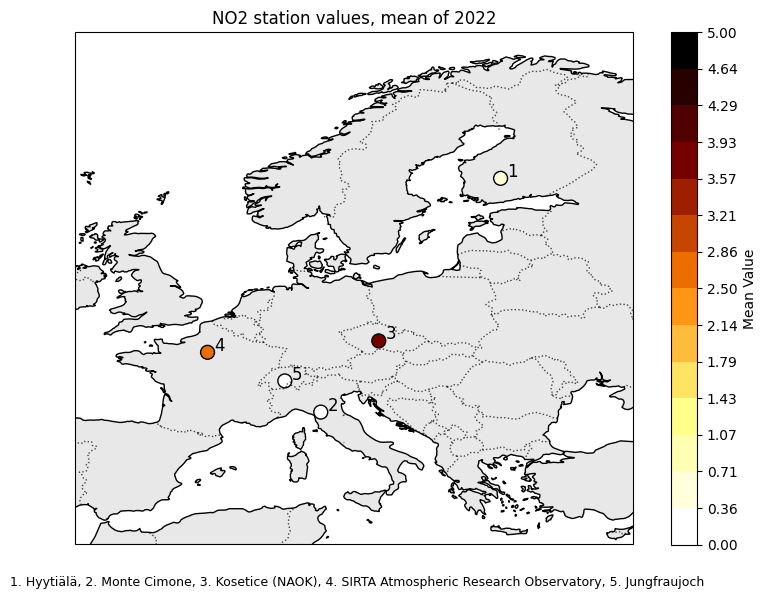

In [15]:


mean_values=[]
latitudes=[]
longitudes=[]

for site in monthly_means_all_sites:
    meanvalues = np.nanmean(site.values.tolist())  # Convert the DataArray values to a list and average values over all 12 months
    lat = site.attrs['ebas_station_latitude']
    lon = site.attrs['ebas_station_longitude']

    mean_values.append(meanvalues)
    latitudes.append(lat)
    longitudes.append(lon)


# Convert longitudes and latitudes to float if they are not already
longitudes = np.array(longitudes).astype(float)
latitudes = np.array(latitudes).astype(float)

#Choose max and min - this will depend on your data
minval=0
maxval=5 

# Create the map plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features (coastlines, borders, etc.)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

# Fill the continents with a light grey color
ax.add_feature(cfeature.LAND, facecolor='lightgrey', alpha=0.5)

# Define discrete color levels and the colormap
cmap = get_cmap('afmhot').reversed()  # Choose your colormap, e.g., 'viridis', 'plasma', etc.
ncolors=15 #15 color levels
levels = np.linspace(minval, maxval, ncolors)  # Discrete values for the colorbar (e.g., from 0 to 1)
norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Plot the stations as colored circles
sc = ax.scatter(longitudes, latitudes, c=mean_values, cmap=cmap, norm=norm, s=100, edgecolor='black')

## Add station names as text next to each marker
#for lon, lat, name in zip(longitudes, latitudes, site_name_list):
#    ax.text(lon + 0.5, lat + 0.5, name, fontsize=9,fontweight='bold', ha='left', va='center', transform=ccrs.PlateCarree())

# Numerate the stations on the map
for i, (lon, lat) in enumerate(zip(longitudes, latitudes), start=1):
    ax.text(lon + 0.5, lat + 0.5, str(i), fontsize=12, ha='left', va='center', 
            transform=ccrs.PlateCarree())#, fontweight='bold')

# Add a colorbar with discrete intervals
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Mean Value')
cbar.set_ticks(levels)  # Set colorbar ticks to discrete levels
cbar.ax.set_yticklabels([f'{level:.2f}' for level in levels])  # Customize tick labels if needed

# Set titles, labels, and other map properties
ax.set_title('NO2 station values, mean of '+str(year_interested))

ax.set_extent([min(longitudes) - 10, max(longitudes) + 10, min(latitudes) - 10, max(latitudes) + 10])  # Set the extent of the map

# Add the legend as text, positioned just below the map
legend_text = ", ".join([f"{i}. {name}" for i, name in enumerate(site_name_list, start=1)])
plt.figtext(0.01, 0.02, legend_text, ha="left", fontsize=9, wrap=True)

# Adjust the layout to avoid cutting off the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])

plt.show()
plt.close()

#### Make a climatology plot. 
Monthly mean of NO2 in 2022 at one site is comapred with the earlier 15 years

In [ ]:
ds=xr.open_dataset('https://thredds.nilu.no/thredds/dodsC/ebas_doi/VA/U9/WW/VAU9-WW7S.nc')
ds_last=xr.open_dataset('https://thredds.nilu.no/thredds/dodsC/ebas_doi/DQ/83/EQ/DQ83-EQBE.nc')
ds2_renamed = ds_last.rename({'nitrogen_dioxide_ug_N_per_m3': 'nitrogen_dioxide'})
ds_combined = xr.concat([ds, ds2_renamed], dim='time', )

ds_monthly = ds_combined.resample(time="M").mean()

df=pd.DataFrame(ds_monthly.nitrogen_dioxide.values, index=ds_monthly.time.values, columns=['nitrogen_dioxide'])
df_ex=df[df.index.year != 2022]
df['month'] = df.index.month

df_ex=df[df.index.year != 2022]
df_2022=df[df.index.year == 2022]
monthly_stats = df_ex.groupby('month')['nitrogen_dioxide'].describe()

# Extract relevant statistics
months = monthly_stats.index
max_values = monthly_stats['max']
min_values = monthly_stats['min']
q75_values = monthly_stats['75%']
q25_values = monthly_stats['25%']
median_values = monthly_stats['50%']

# Plot the statistics
plt.figure(figsize=(10, 6))
plt.plot(months, max_values, label='Max',color='blue', alpha=0.1)
plt.plot(months, min_values, label='Min',color='blue', alpha=0.1)
plt.plot(months, q75_values, label='75%', color='green', alpha=0.3)
plt.plot(months, q25_values, label='25%', color='green', alpha=0.3)
plt.plot(months, median_values, label='Median', marker='o')
plt.plot(df_2022['month'], df_2022['nitrogen_dioxide'], label='2022', marker='o', color='red')
# Add shaded area between Max and 75%
plt.fill_between(months, q75_values, max_values, color='gray', alpha=0.3)
plt.fill_between(months, q25_values, q75_values, color='gray', alpha=0.6)
# Add shaded area between Max and 75%
plt.fill_between(months, q25_values, min_values, color='gray', alpha=0.3)


plt.xlabel('Month')
plt.ylabel('Nitrogen Dioxide')
plt.title('Monthly Statistics for Nitrogen Dioxide')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import json
import math

# Assuming monthly_means_all_sites is already defined and contains the necessary data
json_data = []

for site in monthly_means_all_sites:
    values = site.values.tolist()  # Convert the DataArray values to a list
    # Replace NaN values with None
    values = [None if math.isnan(value) else value for value in values]

    json_data.append({
        'station': site.attrs['ebas_station_name'],
        'lat': site.attrs['ebas_station_latitude'],
        'lon': site.attrs['ebas_station_longitude'],
        'values': values
    })

# Convert the list of dictionaries to a JSON string
json_string = json.dumps(json_data, indent=4)

# Write the JSON string to a file
with open('datasets/no2_monthly.json', 'w') as json_file:
    json_file.write(json_string)

print("JSON file created")

JSON file created


In [18]:
!python3 -m http.server 8000

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
127.0.0.1 - - [17/Oct/2024 10:33:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Oct/2024 10:33:12] code 404, message File not found
127.0.0.1 - - [17/Oct/2024 10:33:12] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [17/Oct/2024 10:33:15] "GET /world_no2.html HTTP/1.1" 200 -
127.0.0.1 - - [17/Oct/2024 10:33:15] "GET /datasets/no2_monthly.json HTTP/1.1" 200 -
^C

Keyboard interrupt received, exiting.


In [11]:
#go to the browser and open the following link

http://0.0.0.0:8000/world_no2.html

SyntaxError: invalid syntax (1832037992.py, line 3)

In [ ]:
# dette er en test på om Wenche klarer å psuhe til github